#**Etapa 1**

In [ ]:
import re
from collections import defaultdict
import pandas as pd
# 1. Upload do arquivo
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/etapa_02/instancias/dados/MCGRP/BHW1.dat'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Parser corrigido
def parse_instance_fully_correct(file_path: str):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data = {
        "meta": {},
        "ReN": [],
        "ReE": [],
        "ReA": [],
        "NonRequiredArcs": []
    }

    section = None
    for line in lines:
        line = line.strip()
        if not line or line.startswith("the data is"):
            continue
        if line.startswith("Name:"):
            data["meta"]["name"] = line.split(":")[1].strip()
        elif line.startswith("Capacity:"):
            data["meta"]["capacity"] = int(line.split(":")[1].strip())
        elif line.startswith("Depot Node:"):
            data["meta"]["depot"] = int(line.split(":")[1].strip())
        elif re.match(r"#\w+:", line):
            key, value = line.split(":")
            data["meta"][key.strip()] = int(value.strip())
        elif line.startswith("ReN."):
            section = "ReN"
        elif line.startswith("ReE."):
            section = "ReE"
        elif line.startswith("ReA."):
            section = "ReA"
        else:
            parts = re.split(r'\s+', line)
            if section == "ReN" and len(parts) == 3 and parts[0].startswith("N"):
                nid = int(parts[0][1:])
                demand = int(parts[1])
                scost = int(parts[2])
                data["ReN"].append((nid, demand, scost))
            elif section == "ReE" and len(parts) == 6 and parts[0].startswith("E"):
                _, u, v, cost, demand, scost = parts
                data["ReE"].append((int(u), int(v), int(cost), int(demand), int(scost)))
            elif section == "ReA" and len(parts) == 6 and parts[0].startswith("A"):
                _, u, v, cost, demand, scost = parts
                data["ReA"].append((int(u), int(v), int(cost), int(demand), int(scost)))
            elif (line.startswith("NrA") or line.startswith("ARC")) and len(parts) == 4:
                _, u, v, cost = parts
                data["NonRequiredArcs"].append((int(u), int(v), int(cost)))

    return data

In [ ]:
# 3. Classe do grafo com métricas
class CustomGraphFinal:
    def __init__(self, parsed_data):
        self.V = set()
        self.edges = []
        self.arcs = []
        self.required_nodes = set()
        self.required_edges = []
        self.required_arcs = []
        self.depot = parsed_data["meta"]["depot"]
        self.capacity = parsed_data["meta"]["capacity"]
        self.graph = defaultdict(list)

        self.V.add(self.depot)  # Garante que o depósito está sempre no grafo!

        for node_id, demand, scost in parsed_data["ReN"]:
            self.required_nodes.add(node_id)
            self.V.add(node_id)

        for u, v, cost, demand, scost in parsed_data["ReE"]:
            self.edges.append((u, v, cost))
            self.required_edges.append((u, v, cost, demand, scost))
            self.graph[u].append((v, cost))
            self.graph[v].append((u, cost))
            self.V.add(u)
            self.V.add(v)

        for u, v, cost, demand, scost in parsed_data["ReA"]:
            self.arcs.append((u, v, cost))
            self.required_arcs.append((u, v, cost, demand, scost))
            self.graph[u].append((v, cost))
            self.V.add(u)
            self.V.add(v)

        for u, v, cost in parsed_data["NonRequiredArcs"]:
            self.arcs.append((u, v, cost))
            self.graph[u].append((v, cost))
            self.V.add(u)
            self.V.add(v)

    def num_vertices(self): return len(self.V)
    def num_edges(self): return len(self.edges)
    def num_arcs(self): return len(self.arcs)
    def num_required_nodes(self): return len(self.required_nodes)
    def num_required_edges(self): return len(self.required_edges)
    def num_required_arcs(self): return len(self.required_arcs)

    def density(self):
        n = len(self.V)
        m = len(self.edges) + len(self.arcs)
        return m / (n * (n - 1)) if n > 1 else 0

    def degrees(self):
        degree = defaultdict(int)
        for u in self.graph:
            for v, _ in self.graph[u]:
                degree[u] += 1
        return min(degree.values()), max(degree.values())

    def floyd_warshall(self):
        # Mapeia cada nó para um índice sequencial
        nodes = sorted(list(self.V))
        node_to_index = {node: idx for idx, node in enumerate(nodes)}
        index_to_node = {idx: node for idx, node in enumerate(nodes)}

        n = len(nodes)
        INF = float('inf')
        dist = [[INF]*n for _ in range(n)]
        pred = [[-1]*n for _ in range(n)]

        # Inicializa
        for idx in range(n):
            dist[idx][idx] = 0
            pred[idx][idx] = idx

        for u in self.graph:
            for v, cost in self.graph[u]:
                i = node_to_index[u]
                j = node_to_index[v]
                dist[i][j] = min(dist[i][j], cost)
                pred[i][j] = i

        # Floyd-Warshall
        for k in range(n):
            for i in range(n):
                for j in range(n):
                    if dist[i][k] + dist[k][j] < dist[i][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]
                        pred[i][j] = pred[k][j]

        return dist, pred, node_to_index, index_to_node

    def average_path_length_and_diameter(self, dist):
        n = len(dist)
        values = [dist[i][j] for i in range(n) for j in range(n) if i != j and dist[i][j] < float('inf')]
        return (sum(values) / len(values), max(values)) if values else (float('inf'), float('inf'))

    def connected_components(self):
        visited = set()
        components = []
        def dfs(v, comp):
            visited.add(v)
            comp.append(v)
            for u, _ in self.graph[v]:
                if u not in visited:
                    dfs(u, comp)
        for v in self.V:
            if v not in visited:
                comp = []
                dfs(v, comp)
                components.append(comp)
        return components

    def betweenness_centrality(self, dist, pred):
        n = len(dist)
        bt = {i: 0 for i in range(n)}
        for s in range(n):
            for t in range(n):
                if s != t and pred[s][t] != -1:
                    v = pred[s][t]
                    while v != s and v != -1:
                        bt[v] += 1
                        v = pred[s][v]
        return bt

In [ ]:
parsed_data = parse_instance_fully_correct(file_path)
g = CustomGraphFinal(parsed_data)
dist, pred, node_to_index, index_to_node = g.floyd_warshall()
avg_path, diameter = g.average_path_length_and_diameter(dist)

df = pd.DataFrame([
    ("Quantidade de vértices", g.num_vertices()),
    ("Quantidade de arestas", g.num_edges()),
    ("Quantidade de arcos", g.num_arcs()),
    ("Quantidade de vértices requeridos", g.num_required_nodes()),
    ("Quantidade de arestas requeridas", g.num_required_edges()),
    ("Quantidade de arcos requeridos", g.num_required_arcs()),
    ("Densidade do grafo", g.density()),
    ("Componentes conectados", len(g.connected_components())),
    ("Grau mínimo", g.degrees()[0]),
    ("Grau máximo", g.degrees()[1]),
    ("Caminho médio", avg_path),
    ("Diâmetro", diameter)
], columns=["Métrica", "Valor"])

print(df)
print("\nIntermediação (Betweenness):")
bt_raw = g.betweenness_centrality(dist, pred)
bt = {index_to_node[i]: bt_raw[i] for i in bt_raw}
print(bt)

                              Métrica      Valor
0              Quantidade de vértices  12.000000
1               Quantidade de arestas  11.000000
2                 Quantidade de arcos  22.000000
3   Quantidade de vértices requeridos   7.000000
4    Quantidade de arestas requeridas  11.000000
5      Quantidade de arcos requeridos  11.000000
6                  Densidade do grafo   0.250000
7              Componentes conectados   1.000000
8                         Grau mínimo   3.000000
9                         Grau máximo   5.000000
10                      Caminho médio  16.712121
11                           Diâmetro  30.000000

Intermediação (Betweenness):
{1: 18, 2: 22, 3: 6, 4: 0, 5: 14, 6: 38, 7: 22, 8: 16, 9: 14, 10: 6, 11: 0, 12: 22}


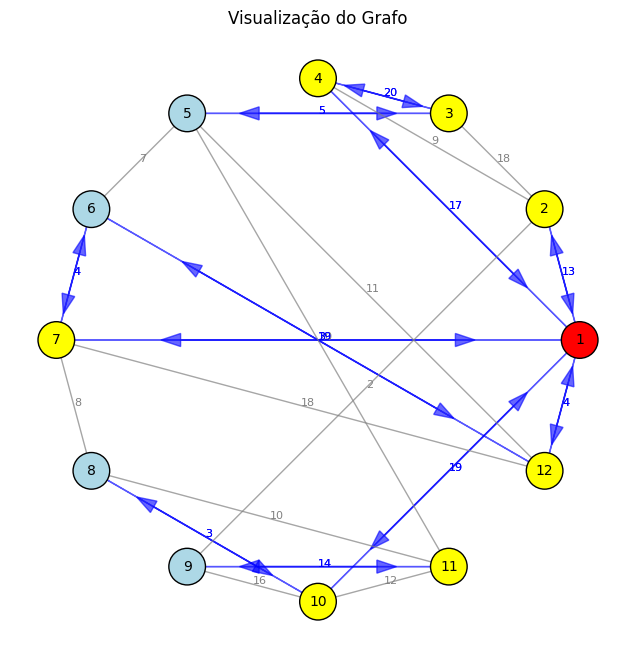

In [ ]:
import matplotlib.pyplot as plt
import math

def desenhar_grafo(grafo):
    nodes = list(grafo.V)
    num_nodes = len(nodes)
    node_pos = {}

    # Distribuir os nós em um círculo
    for i, node in enumerate(nodes):
        angle = 2 * math.pi * i / num_nodes
        x = math.cos(angle)
        y = math.sin(angle)
        node_pos[node] = (x, y)

    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_aspect('equal')

    # Desenhar arestas (não direcionadas)
    for u, v, cost in grafo.edges:
        x1, y1 = node_pos[u]
        x2, y2 = node_pos[v]
        plt.plot([x1, x2], [y1, y2], color='gray', linewidth=1, alpha=0.7)
        mx, my = (x1 + x2) / 2, (y1 + y2) / 2
        plt.text(mx, my, f'{cost}', fontsize=8, color='gray')

    # Desenhar arcos (direcionados)
    for u, v, cost in grafo.arcs:
        x1, y1 = node_pos[u]
        x2, y2 = node_pos[v]
        dx, dy = x2 - x1, y2 - y1
        plt.arrow(x1, y1, dx * 0.8, dy * 0.8, head_width=0.05, length_includes_head=True, color='blue', alpha=0.6)
        mx, my = x1 + dx * 0.5, y1 + dy * 0.5
        plt.text(mx, my, f'{cost}', fontsize=8, color='blue')

    # Desenhar nós
    for node, (x, y) in node_pos.items():
        if node == grafo.depot:
            color = 'red'
        elif node in grafo.required_nodes:
            color = 'yellow'
        else:
            color = 'lightblue'
        circle = plt.Circle((x, y), 0.07, color=color, ec='black', zorder=10)
        ax.add_patch(circle)
        plt.text(x, y, str(node), ha='center', va='center', fontsize=10, zorder=11)

    plt.axis('off')
    plt.title('Visualização do Grafo')
    plt.show()

# 🟦 Chamar a função:
desenhar_grafo(g)


# 🚀 Etapa 2 – Algoritmo Construtivo para MCGRP

Nesta etapa, desenvolvemos e aplicamos um algoritmo construtivo (Savings) para o problema de roteamento em multigrafos com restrições de capacidade.

---

## 1️⃣ Preparação dos Serviços e IDs

Nesta etapa, organizamos todos os serviços (nós, arestas e arcos requeridos) em um dicionário e atribuímos um identificador único para cada serviço.

# Inicialização dos dicionários de serviços e IDs
servicos = {}
servico_ids = {}
id_counter = 1

# Adiciona os serviços de nós requeridos
for node_id, demand, scost in parsed_data["ReN"]:
    servicos[(g.depot, node_id, 'N')] = (demand, scost)
    servico_ids[(g.depot, node_id, 'N')] = id_counter
    id_counter += 1

# Adiciona os serviços de arestas requeridas
for u, v, cost, demand, scost in parsed_data["ReE"]:
    servicos[(u, v, 'E')] = (demand, scost)
    servico_ids[(u, v, 'E')] = id_counter
    id_counter += 1

# Adiciona os serviços de arcos requeridos
for u, v, cost, demand, scost in parsed_data["ReA"]:
    servicos[(u, v, 'A')] = (demand, scost)
    servico_ids[(u, v, 'A')] = id_counter
    id_counter += 1


## 2️⃣ Classe Rota

A classe `Rota` representa uma solução parcial, armazenando o caminho, carga, custo e serviços realizados em uma rota de veículo.

In [ ]:
class Rota:
    def __init__(self, deposito, capacidade):
        self.rota = [deposito]  # Sequência de nós visitados
        self.carga = 0
        self.capacidade = capacidade
        self.custo = 0
        self.servicos_realizados = []    # Lista de serviços realizados
        self.servicos_atendidos = set()  # Conjunto para checar duplicidades

    def pode_adicionar(self, demanda):
        """Verifica se é possível adicionar um serviço sem exceder a capacidade."""
        return self.carga + demanda <= self.capacidade

    def adicionar_servico(self, origem, destino, id_serv, custo_real, demanda, tipo_servico, pred=None):
        """Adiciona um serviço à rota."""
        self.rota.append(destino)
        self.custo += custo_real
        self.carga += demanda
        self.servicos_realizados.append((id_serv, origem, destino, tipo_servico))
        self.servicos_atendidos.add((origem, destino, tipo_servico))

## 3️⃣ Funções de Inicialização das Rotas e Savings

Estas funções implementam a estratégia Savings para combinar rotas iniciais.

In [ ]:
import copy

def inicializa_rotas_savings(servicos, deposito, servico_ids):
    """Cria uma rota inicial para cada serviço, isoladamente."""
    rotas = {}
    for (u, v, tipo), (demanda, scost) in servicos.items():
        id_serv = servico_ids[(u, v, tipo)]
        rota = {
            "servicos": [(id_serv, u, v, tipo)],
            "nos": [deposito, u, v, deposito] if u != deposito else [deposito, v, deposito],
            "carga": demanda,
            "custo": scost,
            "caminho": [(u, v, tipo)]
        }
        rotas[(u, v, tipo)] = rota
    return rotas

def calcula_savings(rotas, deposito, matriz_custos, node_to_index):
    """Calcula a matriz de savings para pares de rotas."""
    savings = []
    chaves = list(rotas.keys())
    for i in range(len(chaves)):
        for j in range(i+1, len(chaves)):
            s1 = rotas[chaves[i]]
            s2 = rotas[chaves[j]]
            end1 = s1["nos"][-2]
            start2 = s2["nos"][1]
            i_depot = node_to_index[deposito]
            i_end1 = node_to_index[end1]
            i_start2 = node_to_index[start2]
            saving = matriz_custos[i_depot][i_end1] + matriz_custos[i_depot][i_start2] - matriz_custos[i_end1][i_start2]
            savings.append(((chaves[i], chaves[j]), saving))
    savings.sort(key=lambda x: -x[1])
    return savings

def pode_fundir(rot1, rot2, capacidade):
    """Verifica se é possível unir duas rotas sem exceder a capacidade."""
    return rot1["carga"] + rot2["carga"] <= capacidade

def fundir_rotas(rot1, rot2, matriz_custos, deposito, servicos, node_to_index):
    """Funde duas rotas em uma nova rota."""
    nova_nos = rot1["nos"][:-1] + rot2["nos"][1:]
    nova_servicos = rot1["servicos"] + rot2["servicos"]
    nova_caminho = rot1["caminho"] + rot2["caminho"]
    nova_carga = rot1["carga"] + rot2["carga"]
    custo = 0
    for i in range(len(nova_nos)-1):
        custo += matriz_custos[node_to_index[nova_nos[i]]][node_to_index[nova_nos[i+1]]]
    custo += sum(servicos[(u, v, tipo)][1] for (id_serv, u, v, tipo) in nova_servicos)
    return {
        "servicos": nova_servicos,
        "nos": nova_nos,
        "carga": nova_carga,
        "custo": custo,
        "caminho": nova_caminho
    }

## 4️⃣ Funções de Checagem de Viabilidade de Caminhos

Estas funções avaliam se os caminhos gerados são válidos (não passam por arestas inexistentes) e determinam quais nós são acessíveis a partir do depósito.

In [ ]:
def caminho_totalmente_viavel(nos, matriz_custos, node_to_index):
    """Verifica se todas as arestas do caminho existem (não há custos infinitos)."""
    for i in range(len(nos) - 1):
        if matriz_custos[node_to_index[nos[i]]][node_to_index[nos[i+1]]] == float('inf'):
            return False
    return True

from collections import deque

def acessiveis_do_deposito(grafo, deposito):
    """Retorna todos os nós acessíveis a partir do depósito (BFS)."""
    visited = set()
    fila = deque([deposito])
    while fila:
        v = fila.popleft()
        if v in visited:
            continue
        visited.add(v)
        for u, _ in grafo.graph[v]:
            if u not in visited:
                fila.append(u)
    return visited

# Checa nós inacessíveis a partir do depósito
acessiveis = acessiveis_do_deposito(g, g.depot)
inacessiveis = [n for n in g.required_nodes if n not in acessiveis]
if inacessiveis:
    print(f"Nós inacessíveis a partir do depósito: {inacessiveis}")

## 5️⃣ Algoritmo Construtivo Savings

Executa o procedimento completo do savings para gerar rotas finais válidas e eficientes.

In [ ]:
def construtivo_savings(g, servicos, servico_ids, deposito, capacidade, matriz_custos, node_to_index):
    """Algoritmo construtivo baseado no Savings de Clarke & Wright."""
    rotas = inicializa_rotas_savings(servicos, deposito, servico_ids)
    savings = calcula_savings(rotas, deposito, matriz_custos, node_to_index)
    rotas_chave = copy.deepcopy(rotas)
    service_to_route = {k: k for k in rotas_chave}

    for (par, saving) in savings:
        k1, k2 = par
        r1_chave = service_to_route[k1]
        r2_chave = service_to_route[k2]
        if r1_chave == r2_chave:
            continue
        rot1 = rotas_chave[r1_chave]
        rot2 = rotas_chave[r2_chave]
        if rot1["nos"][-2] == rot2["nos"][1]:
            continue

        nova_rota_temp = fundir_rotas(rot1, rot2, matriz_custos, deposito, servicos, node_to_index)
        nos = nova_rota_temp["nos"]
        if pode_fundir(rot1, rot2, capacidade) and caminho_totalmente_viavel(nos, matriz_custos, node_to_index):
            nova_rota = nova_rota_temp
            del rotas_chave[r1_chave]
            del rotas_chave[r2_chave]
            nova_key = tuple(sorted(rot1["servicos"] + rot2["servicos"]))
            rotas_chave[nova_key] = nova_rota
            for s in rot1["caminho"] + rot2["caminho"]:
                service_to_route[s] = nova_key

    rotas_finais = []
    for rota_dict in rotas_chave.values():
        nos = rota_dict["nos"]
        if not caminho_totalmente_viavel(nos, matriz_custos, node_to_index):
            continue
        rota_obj = Rota(deposito, capacidade)
        rota_obj.rota = rota_dict["nos"]
        rota_obj.carga = rota_dict["carga"]
        rota_obj.custo = rota_dict["custo"]
        for (id_serv, u, v, tipo) in rota_dict["servicos"]:
            rota_obj.servicos_realizados.append((id_serv, u, v, tipo))
            rota_obj.servicos_atendidos.add((u, v, tipo))
        rotas_finais.append(rota_obj)
    return rotas_finais

## 6️⃣ Impressão da Solução no Padrão `.sol`

Esta função imprime as soluções geradas no formato exigido pela disciplina.

In [ ]:
def print_solucao_padroes(solucoes, nome_instancia, servico_ids, clocks_ref=0, clocks_sol=0):
    """Imprime a solução no padrão solicitado pelo professor."""
    custo_total = int(sum(r.custo for r in solucoes))
    print(f"{custo_total}")
    print(f"{len(solucoes)}")
    print(f"{clocks_ref}")  # clocks do algoritmo referência (coloque o valor correto se medir, senão deixe 0)
    print(f"{clocks_sol}")  # clocks para encontrar a solução referência (idem)

    for idx, rota in enumerate(solucoes, start=1):
        num_servicos = len(rota.servicos_realizados)
        carga = int(rota.carga)
        tam_rota = len(rota.rota)

        # Trate custo infinito explicitamente
        if rota.custo == float('inf') or rota.custo != rota.custo:  # float('inf') e NaN
            print(f"# ⚠ Atenção: rota {idx} possui custo infinito ou inválido e será ignorada.")
            continue

        custo = int(rota.custo)
        # Cabeçalho da linha
        linha = f"0 1 {idx} {num_servicos} {custo} {carga} {tam_rota}"
        # Primeira visita ao depósito
        linha += f" (D {rota.rota[0]},{rota.rota[1]},{rota.rota[1]})"
        # Serviços realizados
        for i in range(1, tam_rota - 1):
            u = rota.rota[i-1]
            v = rota.rota[i]
            id_serv = None
            for tipo in ['N', 'E', 'A']:
                if (u, v, tipo) in servico_ids:
                    id_serv = servico_ids[(u, v, tipo)]
                    break
            if id_serv is not None:
                linha += f" (S {id_serv},{u},{v})"
        # Última visita ao depósito
        linha += f" (D {rota.rota[-2]},{rota.rota[-1]},{rota.rota[-1]})"
        # Agora sim, imprime e quebra linha
        print(linha)

## 7️⃣ Execução para uma Única Instância (Exemplo)

A seguir, um exemplo completo de execução do algoritmo para uma instância.


In [ ]:
# 1. Prepare os serviços e IDs (caso não tenha feito anteriormente)
servicos = {}
servico_ids = {}
id_counter = 1
for node_id, demand, scost in parsed_data["ReN"]:
    servicos[(g.depot, node_id, 'N')] = (demand, scost)
    servico_ids[(g.depot, node_id, 'N')] = id_counter
    id_counter += 1
for u, v, cost, demand, scost in parsed_data["ReE"]:
    servicos[(u, v, 'E')] = (demand, scost)
    servico_ids[(u, v, 'E')] = id_counter
    id_counter += 1
for u, v, cost, demand, scost in parsed_data["ReA"]:
    servicos[(u, v, 'A')] = (demand, scost)
    servico_ids[(u, v, 'A')] = id_counter
    id_counter += 1

# 2. Execute o algoritmo Savings
solucoes = construtivo_savings(
    g,
    servicos,
    servico_ids,
    g.depot,
    g.capacity,
    dist,
    node_to_index
)

# 3. Imprima a solução no padrão exigido
print_solucao_padroes(
    solucoes,
    parsed_data["meta"]["name"],
    servico_ids,
    clocks_ref=0,
    clocks_sol=0
)

## 8️⃣ Execução em Lote para Todas as Instâncias

Processa todas as instâncias em um diretório e salva as soluções.


In [ ]:
import os
import glob
from contextlib import redirect_stdout
import traceback
import time

INPUT_DIR  = '/content/drive/MyDrive/Colab Notebooks/etapa_02/instancias/dados/MCGRP'
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/etapa_02/solucoes'
os.makedirs(OUTPUT_DIR, exist_ok=True)

for filepath in sorted(glob.glob(os.path.join(INPUT_DIR, '*.dat'))):
    inst_name = os.path.splitext(os.path.basename(filepath))[0]
    out_path = os.path.join(OUTPUT_DIR, f'sol-{inst_name}.dat')
    print(f'▶ Processando {inst_name} → {out_path}')

    try:
        with open(out_path, 'w') as fout, redirect_stdout(fout):
            data = parse_instance_fully_correct(filepath)
            g = CustomGraphFinal(data)
            dist, pred, node_to_index, index_to_node = g.floyd_warshall()

            # Reinicializa os serviços para cada instância!
            servicos = {}
            servico_ids = {}
            id_counter = 1
            for node_id, demand, scost in data["ReN"]:
                servicos[(g.depot, node_id, 'N')] = (demand, scost)
                servico_ids[(g.depot, node_id, 'N')] = id_counter
                id_counter += 1
            for u, v, cost, demand, scost in data["ReE"]:
                servicos[(u, v, 'E')] = (demand, scost)
                servico_ids[(u, v, 'E')] = id_counter
                id_counter += 1
            for u, v, cost, demand, scost in data["ReA"]:
                servicos[(u, v, 'A')] = (demand, scost)
                servico_ids[(u, v, 'A')] = id_counter
                id_counter += 1

            try:
                start_alg = time.perf_counter()
                solucoes = construtivo_savings(
                    g, servicos, servico_ids, g.depot, g.capacity, dist, node_to_index
                )
                end_alg = time.perf_counter()
                clocks_ref = int((end_alg - start_alg) * 1e6)
            except (IndexError, OverflowError) as e:
                print(f'# ⚠ Erro no savings: {e}')
                solucoes = []
                clocks_ref = 0

            if solucoes:
                try:
                    print_solucao_padroes(
                        solucoes,
                        data["meta"]["name"],
                        servico_ids,
                        clocks_ref=clocks_ref,
                        clocks_sol=clocks_ref
                    )
                except OverflowError as e:
                    print(f'# ⚠ Erro ao imprimir solução: {e}')
            else:
                print(f'# ⚠ Nenhuma rota gerada para {inst_name} devido a erro interno.')

        print(f'✅ OK: {out_path}')
    except Exception as e:
        print(f'❌ NÃO GERADO: {inst_name} → {e.__class__.__name__}')
        traceback.print_exc()